In [ ]:
# =========================
# Celda 0 — SETUP (seed=42)
# =========================
import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

import warnings, random, numpy as np, pandas as pd
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

RANDOM_STATE = 42
def _seed(s=RANDOM_STATE):
    random.seed(s); np.random.seed(s)
_seed()

# ---------- RUTAS / OBJETIVO ----------
FILES   = {"muy_corto": ("AMZN_modelo_muy_corto_train.csv", None)} 
SPLITS  = 5
GAP_MAP = {"muy_corto": 1}  # 1 día hábil

# ---------- Métricas ----------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def _rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def _mae (y, yhat): return float(mean_absolute_error(y, yhat))
def _r2  (y, yhat): return float(r2_score(y, yhat))
def _hit (y, yhat): 
    try: return float((np.sign(y) == np.sign(yhat)).mean())
    except Exception: return np.nan

# ---------- Carga de datos (autodetecta target_1d) ----------
def _guess_target_1d(cols):
    cand = [
        "target_1d_logret_fwd","target_1d","y_1d","ret_1d_fwd_log","ret_1d_fwd","y"
    ]
    for c in cand:
        if c in cols: return c
    # fallback: la única col que contenga simultáneamente '1' y ('fwd' o 'target')
    for c in cols:
        lc = c.lower()
        if "1" in lc and (("fwd" in lc) or ("target" in lc)): return c
    raise ValueError("No encuentro columna objetivo de 1 día (e.g., 'target_1d_logret_fwd').")

def load_xy(csv_path, target_col=None, date_col="Date"):
    df = pd.read_csv(csv_path)

    # Orden robusto por fecha (soporta dd-mm-yy e ISO). Usa 'by' + 'key' (no pasar la Serie a 'by').
    if date_col in df.columns:
        df = df.sort_values(
            by=date_col,
            key=lambda s: pd.to_datetime(s, dayfirst=True, errors="coerce")
        ).reset_index(drop=True)

    # Detección del target si no se pasó explícito
    if target_col is None:
        target_col = _guess_target_1d(df.columns)

    # Selección de features numéricas (excluye el target)
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    if target_col not in df.columns:
        raise ValueError(f"No encuentro la columna objetivo: {target_col}")

    feats = [c for c in num_cols if c != target_col]
    X = df[feats].values
    y = df[target_col].values.astype(float)
    return df, X, y, feats, target_col

# ---------- Splits WF con purgado/embargo ----------
def _feasible_folds(n, train_min, val_size, gap):
    numer = n - train_min - gap - val_size
    if numer < 0: return 0
    return (numer // val_size) + 1

def make_wf_splits_capped(n, train_min, val_size, n_splits, gap=0):
    use = min(n_splits, _feasible_folds(n, train_min, val_size, gap))
    splits = []
    for i in range(use):
        train_end = train_min + i * val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits

# ---------- Evaluación CV purgado ----------
from sklearn.base import clone
def eval_model_wf(estimator, X, y, splits):
    y_all, yhat_all = [], []
    for tr, va in splits:
        est = clone(estimator)
        est.fit(X[tr], y[tr])
        yh = est.predict(X[va])
        y_all.append(y[va]); yhat_all.append(yh)
    y_all = np.concatenate(y_all) if y_all else np.array([])
    yhat_all = np.concatenate(yhat_all) if yhat_all else np.array([])
    if y_all.size == 0:
        return {"rmse": np.nan, "mae": np.nan, "r2": np.nan, "hit": np.nan}
    return {
        "rmse": _rmse(y_all, yhat_all),
        "mae" : _mae (y_all, yhat_all),
        "r2"  : _r2  (y_all, yhat_all),
        "hit" : _hit (y_all, yhat_all),
    }

# ---------- Modelos (tuned) ----------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
inner_cv = TimeSeriesSplit(n_splits=3)

# Lineales
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
LINEALES = {
    "OLS (ref)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg",     LinearRegression())
    ]),
    "Lasso(tuned)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg",     LassoCV(alphas=np.logspace(-4,0,25),
                            cv=inner_cv, max_iter=20000, random_state=RANDOM_STATE))
    ]),
    "ElasticNet(tuned)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg",     ElasticNetCV(l1_ratio=[0.1,0.3,0.5,0.7,0.9],
                                 alphas=np.logspace(-4,0,25),
                                 cv=inner_cv, max_iter=20000, random_state=RANDOM_STATE))
    ]),
}

# Random Forest (determinista)
from sklearn.ensemble import RandomForestRegressor
RF_TUNED = RandomForestRegressor(
    n_estimators=600, max_depth=8, min_samples_leaf=7,
    max_features=0.7, bootstrap=True,
    random_state=RANDOM_STATE, n_jobs=1
)

# XGBoost (tuned p/ muy corto)
try:
    from xgboost import XGBRegressor
    XGB_TUNED = XGBRegressor(
        n_estimators=600, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=1,
        reg_alpha=0.0, reg_lambda=1.0, objective="reg:squarederror",
        tree_method="hist", eval_metric="rmse",
        random_state=RANDOM_STATE, n_jobs=1, verbosity=0
    )
    ENABLE_XGB = True
except Exception:
    ENABLE_XGB = False

# MLP (tuned)
from sklearn.neural_network import MLPRegressor
def make_mlp_tuned(hidden=(64,), alpha=1e-5):
    return Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg",     MLPRegressor(
            hidden_layer_sizes=hidden, activation="tanh",
            solver="lbfgs", alpha=alpha,
            max_iter=20000, tol=1e-6,
            random_state=RANDOM_STATE,
        ))
    ])

# GRU (tuned) — helpers
try:
    import tensorflow as tf
    from tensorflow import keras
    TF_OK = True
    tf.get_logger().setLevel("ERROR")
    tf.keras.utils.set_random_seed(RANDOM_STATE)
except Exception:
    TF_OK = False

def _fit_imputer_scaler(Xtr):
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    imp = SimpleImputer().fit(Xtr)
    sc  = StandardScaler().fit(imp.transform(Xtr))
    class PIPE:
        def __init__(self, imp, sc): self.imp, self.sc = imp, sc
        def transform(self, X): return self.sc.transform(self.imp.transform(X))
    return PIPE(imp, sc)

def _build_seq(X, y, lookback=20):
    n, d = X.shape
    if n <= lookback: return np.zeros((0, lookback, d)), np.zeros((0,))
    Xs = np.array([X[i-lookback:i] for i in range(lookback, n)])
    ys = y[lookback:n]
    return Xs, ys

def make_gru(input_shape, units=64, l2=1e-3, dropout=0.1):
    if not TF_OK: return None
    reg = keras.regularizers.l2(l2)
    inp = keras.layers.Input(shape=input_shape)
    x = keras.layers.GRU(units, kernel_regularizer=reg, recurrent_regularizer=reg,
                         dropout=dropout, return_sequences=False)(inp)
    out = keras.layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
    return m


In [ ]:
# ============================================
# Celda 1 — MUY CORTO (1 día): evaluación CV
# ============================================
csv_path, _ = FILES["muy_corto"]
gap = GAP_MAP["muy_corto"]

# Datos
df_raw, X, y, feats, target_col = load_xy(csv_path, target_col=None)
N = len(df_raw)

# Geometría (análogo a corto/medio): val_size ~ N/12, mínimo 50; train_min >= 200
val_size  = max(50, N // 12)
train_min = max(200, val_size * 2)

# Splits WF purgados con gap=1
splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)
if len(splits) == 0:
     val_size  = max(30, N // 20)
    train_min = max(200, val_size * 2)
    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)

# --- baseline(media) usando los splits
YBAR = float(np.mean(y))
y_val_all = np.concatenate([y[va] for _, va in splits]) if len(splits) else np.array([])
RMSE_MEDIA = float(np.sqrt(np.mean((y_val_all - YBAR)**2))) if y_val_all.size else np.nan

# --- catálogo de modelos
modelos = []
modelos.append(("OLS (ref)", LINEALES["OLS (ref)"]))
modelos.append(("Lasso(tuned)", LINEALES["Lasso(tuned)"]))
modelos.append(("ElasticNet(tuned)", LINEALES["ElasticNet(tuned)"]))
modelos.append(("RF(tuned)", RF_TUNED))
if ENABLE_XGB: modelos.append(("XGB(tuned)", XGB_TUNED))
modelos.append(("MLP(tuned)", make_mlp_tuned(hidden=(64,), alpha=1e-5)))

rows = []

for nombre, est in modelos:
    m = eval_model_wf(est, X, y, splits)
    rows.append({
        "modelo": nombre,
        "rmse": m["rmse"], "mae": m["mae"], "r2": m["r2"], "hit": m["hit"],
        "skill_vs_media": (1.0 - m["rmse"]/RMSE_MEDIA) if RMSE_MEDIA > 0 else np.nan
    })

# GRU (tuned)
if TF_OK:
    y_all, yhat_all = [], []
    for tr, va in splits:
        sc = _fit_imputer_scaler(X[tr])
        Xtr_s, Xva_s = sc.transform(X[tr]), sc.transform(X[va])
        Xtr_seq, ytr = _build_seq(Xtr_s, y[tr], lookback=20)
        Xva_seq, yva = _build_seq(Xva_s, y[va], lookback=20)
        if Xtr_seq.shape[0]==0 or Xva_seq.shape[0]==0:
            continue
        nseq = Xtr_seq.shape[0]
        cut = max(1, int(0.8*nseq))
        Xtr_i, ytr_i = Xtr_seq[:cut], ytr[:cut]
        val_data = (Xtr_seq[cut:], ytr[cut:]) if cut < nseq else None

        gru = make_gru(input_shape=Xtr_seq.shape[1:], units=64, l2=1e-3, dropout=0.1)
        cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)] if val_data else []
        gru.fit(Xtr_i, ytr_i, epochs=150, batch_size=64, verbose=0, validation_data=val_data, callbacks=cb)

        yhat = gru.predict(Xva_seq, verbose=0).ravel()
        y_all.append(yva); yhat_all.append(yhat)

    if y_all:
        y_all = np.concatenate(y_all); yhat_all = np.concatenate(yhat_all)
        rm_gru = _rmse(y_all, yhat_all); mae_gru = _mae(y_all, yhat_all)
        r2_gru = _r2(y_all, yhat_all); hit_gru = _hit(y_all, yhat_all)
        rows.append({
            "modelo": "GRU(tuned)",
            "rmse": rm_gru, "mae": mae_gru, "r2": r2_gru, "hit": hit_gru,
            "skill_vs_media": (1.0 - rm_gru/RMSE_MEDIA) if RMSE_MEDIA > 0 else np.nan
        })
    else:
        rows.append({"modelo":"GRU(tuned)","rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_vs_media":np.nan})
else:
    rows.append({"modelo":"GRU(tuned)","rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_vs_media":np.nan})

# --- baseline(media) como fila
from sklearn.metrics import r2_score
base_df = pd.DataFrame([{
    "modelo": "Baseline(media)",
    "rmse": RMSE_MEDIA,
    "mae":  float(np.mean(np.abs(y_val_all - YBAR))) if y_val_all.size else np.nan,
    "r2":   float(r2_score(y_val_all, np.full_like(y_val_all, YBAR))) if y_val_all.size else np.nan,
    "hit":  float((np.sign(y_val_all) == np.sign(YBAR)).mean()) if y_val_all.size else np.nan,
    "skill_vs_media": 0.0
}])

# --- TABLA FINAL ORDENADA POR RMSE
res_muycorto = pd.concat([pd.DataFrame(rows), base_df], ignore_index=True).sort_values("rmse").reset_index(drop=True)
res_muycorto


,modelo,rmse,mae,r2,hit,skill_vs_media
0,Baseline(media),0.026176,0.018880,-0.000960,0.498,0.000000
1,Lasso(tuned),0.026199,0.018907,-0.002724,0.482,-0.000881
2,ElasticNet(tuned),0.026199,0.018907,-0.002724,0.482,-0.000881
3,RF(tuned),0.028096,0.020178,-0.153162,0.476,-0.073339
4,XGB(tuned),0.035423,0.025527,-0.833134,0.462,-0.353284
5,OLS (ref),0.038168,0.029323,-1.128211,0.478,-0.458139
6,GRU(tuned),0.097424,0.063739,-12.533232,0.510,-2.721917
7,MLP(tuned),0.114688,0.090058,-18.215606,0.514,-3.381459


In [1]:
# ======================================================
# Celda 2 — Guardar FINAL (1 d) Baseline(media) + predict() + meta
# ======================================================
from joblib import dump, load
import pandas as pd, numpy as np, json
from sklearn.dummy import DummyRegressor

# (Informativo)
try:
    best_name = res_muycorto.loc[0, "modelo"]
except Exception:
    best_name = "N/A"
print(f"Mejor modelo por RMSE (1 d, informativo): {best_name}")

# Carga CSV y detecta target si FILES['muy_corto'] viene sin target
csv_path, target_col = FILES["muy_corto"]
df_raw = pd.read_csv(csv_path)
if "Date" in df_raw.columns:
    df_raw = df_raw.sort_values("Date").reset_index(drop=True)

num_cols = df_raw.select_dtypes(include=["number"]).columns.tolist()

def _infer_target(df, provided):
    if provided and provided in df.columns:
        return provided
    prefs = [
        "target_1d_logret_fwd","target_1d_return_fwd","target_1d",
        "ret_1d_fwd","fwd_ret_1d","y_1d","y"
    ]
    for c in prefs:
        if c in df.columns:
            return c
    target_like = [c for c in df.columns if c.lower().startswith("target")]
    if len(target_like) == 1: return target_like[0]
    raise ValueError("No encuentro la columna objetivo para 1d.")

target_col = _infer_target(df_raw, target_col)

# X como DataFrame (consistencia con otros horizontes)
feats = [c for c in num_cols if c != target_col]
X_df = df_raw[feats]
y = df_raw[target_col]

# Modelo FINAL = media constante
y_mean = float(y.mean())
final_model = DummyRegressor(strategy="constant", constant=y_mean)
final_model.fit(X_df, y)  # para dejar n_features_in_

# --- Compatibilidad con tu loader / explicador ---
# (evita que busque coeficientes o importancias no existentes)
final_model.feature_names_in_   = np.array(feats, dtype=object)
final_model.is_baseline_        = True
final_model.baseline_mean_      = y_mean
final_model.coef_               = np.zeros(len(feats), dtype=float)
final_model.feature_importances_= np.zeros(len(feats), dtype=float)

# Guardado del modelo y baseline
MODEL_PATH = "model_1d.joblib"
dump(final_model, MODEL_PATH)
with open("baseline_1d_media.txt", "w") as f:
    f.write(str(y_mean))

# Meta para la app (por si quieres saltarte drivers en el generador)
meta = {"horizon":"1d","type":"baseline_mean","mean":y_mean}
with open("model_1d_meta.json","w") as f:
    json.dump(meta, f)

print(f"Modelo guardado en: {MODEL_PATH}")
print(f"Baseline media (1 d): {y_mean:.6f}")
print(f"Target detectado: {target_col}")
print(f"Nº de features: {len(feats)}")

# Predicción para la app: SIEMPRE la media (blindado)
def predict_1d(df_features):
    with open("baseline_1d_media.txt") as f:
        mu = float(f.read().strip())
    return np.full(len(df_features), mu, dtype=float)

def predict_1d_media(n):
    with open("baseline_1d_media.txt") as f:
        mu = float(f.read().strip())
    return np.full(n, mu, dtype=float)


c:\Users\gabri\anaconda3\envs\tfm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- ANÁLISIS NARRATIVO Amazon (AMZN) (1d) ---

   AUDITORÍA - 2025-11-24 - MODELO: DummyRegressor
>> MODO 1 DÍA DETECTADO: Omitiendo SHAP (Modelo Constante).

>> Redactando noticia con GPT-4o...

--------------------------------------------------------------------------------
Cuando se trata de analizar el comportamiento del mercado en plazos tan cortos como un solo día, es
importante entender que los movimientos de precios son inherentemente caóticos e impredecibles. Esto
se debe a que los mercados financieros están influenciados por una multitud de factores que pueden
cambiar rápidamente, haciendo que cualquier intento de prever con precisión el movimiento diario de
una acción como Amazon (AMZN) sea prácticamente imposible. En este contexto, la mejor herramienta
que tenemos es la media histórica diaria, que para Amazon sugiere un ligero cambio del 0.03%. Sin
embargo, es crucial recordar que este porcentaje es simplemente una referencia estadística y no una
predicción definitiva.  En 

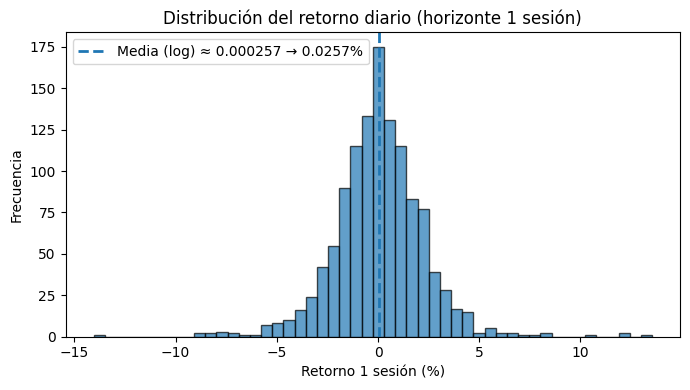

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# y es target_1d_logret_fwd (log-retorno)
y_mean_log = y.mean()
mean_pct = (np.exp(y_mean_log) - 1.0) * 100.0   # media en %

rets_pct = (np.exp(y) - 1.0) * 100.0

plt.figure(figsize=(7, 4))
plt.hist(rets_pct, bins=50, edgecolor="black", alpha=0.7)

plt.axvline(
    mean_pct,
    linestyle="--",
    linewidth=2,
    label=f"Media (log) ≈ {y_mean_log:.6f} → {mean_pct:.4f}%")

plt.title("Distribución del retorno diario (horizonte 1 sesión)")
plt.xlabel("Retorno 1 sesión (%)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()


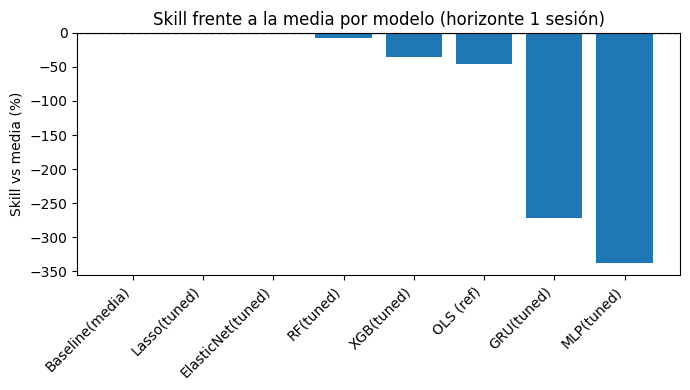

In [ ]:
import matplotlib.pyplot as plt

plot_df = res_muycorto.copy()
# Paso el skill a porcentaje para que se interprete mejor
plot_df["skill_vs_media_pct"] = 100 * plot_df["skill_vs_media"]

plt.figure(figsize=(7, 4))
# Dibujo las barras de skill_vs_media por modelo
plt.bar(plot_df["modelo"], plot_df["skill_vs_media_pct"])

# Línea horizontal en 0 (baseline)
plt.axhline(0, linestyle="--", linewidth=1)

plt.title("Skill frente a la media por modelo (horizonte 1 sesión)")
plt.ylabel("Skill vs media (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [7]:
print(y.mean())        # log-retorno medio
print(mean_pct)        # porcentaje medio


0.00025676732645966364
0.05079959317181539
